<a href="https://colab.research.google.com/github/ahmedimf1/DataScience/blob/master/DETR_People_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt 

%config InlineBackend.figure_format = 'retina'

import requests
import torch as th
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
th.set_grad_enabled(False);

# **Model**

In [ ]:
model = th.hub.load("facebookresearch/detr", "detr_resnet101", pretrained = True)
model.eval()

In [ ]:
model = model.cuda() ##GPU Usage

In [ ]:
# PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [ ]:
#output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return th.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * th.tensor([img_w, img_h, img_w, img_h], dtype=th.float32).cuda()
    return b

In [ ]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).cuda()

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # to use images with an aspect ratio outside this range, rescale your image so that the maximum size is at most 1333.
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

def plot_results(pil_img, prob, boxes):
    n=0
    plt.figure(figsize=(32,20))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
      cl = p.argmax()
      if CLASSES[cl] == "person":
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{CLASSES[cl]} {n}: {p[cl]:0.2f}'
        ax.text(xmax, ymax+10, text, fontsize=15, color = c,
                  bbox=dict(facecolor='white',alpha=0.8))
        peoplePos["person" + str(n)]= [(xmax-xmin)/2, (ymax-ymin)/2, (ymax-ymin)]
        n+=1
    plt.axis('off')
    plt.show()
    

peoplePos = dict()

# Image Input and Visualization



Paste Image url: https://previews.123rf.com/images/irstone/irstone1905/irstone190500094/122152754-london-uk-25-april-2019-city-of-london-busy-street-with-view-at-the-gherkin-building-at-the-backgrou.jpg


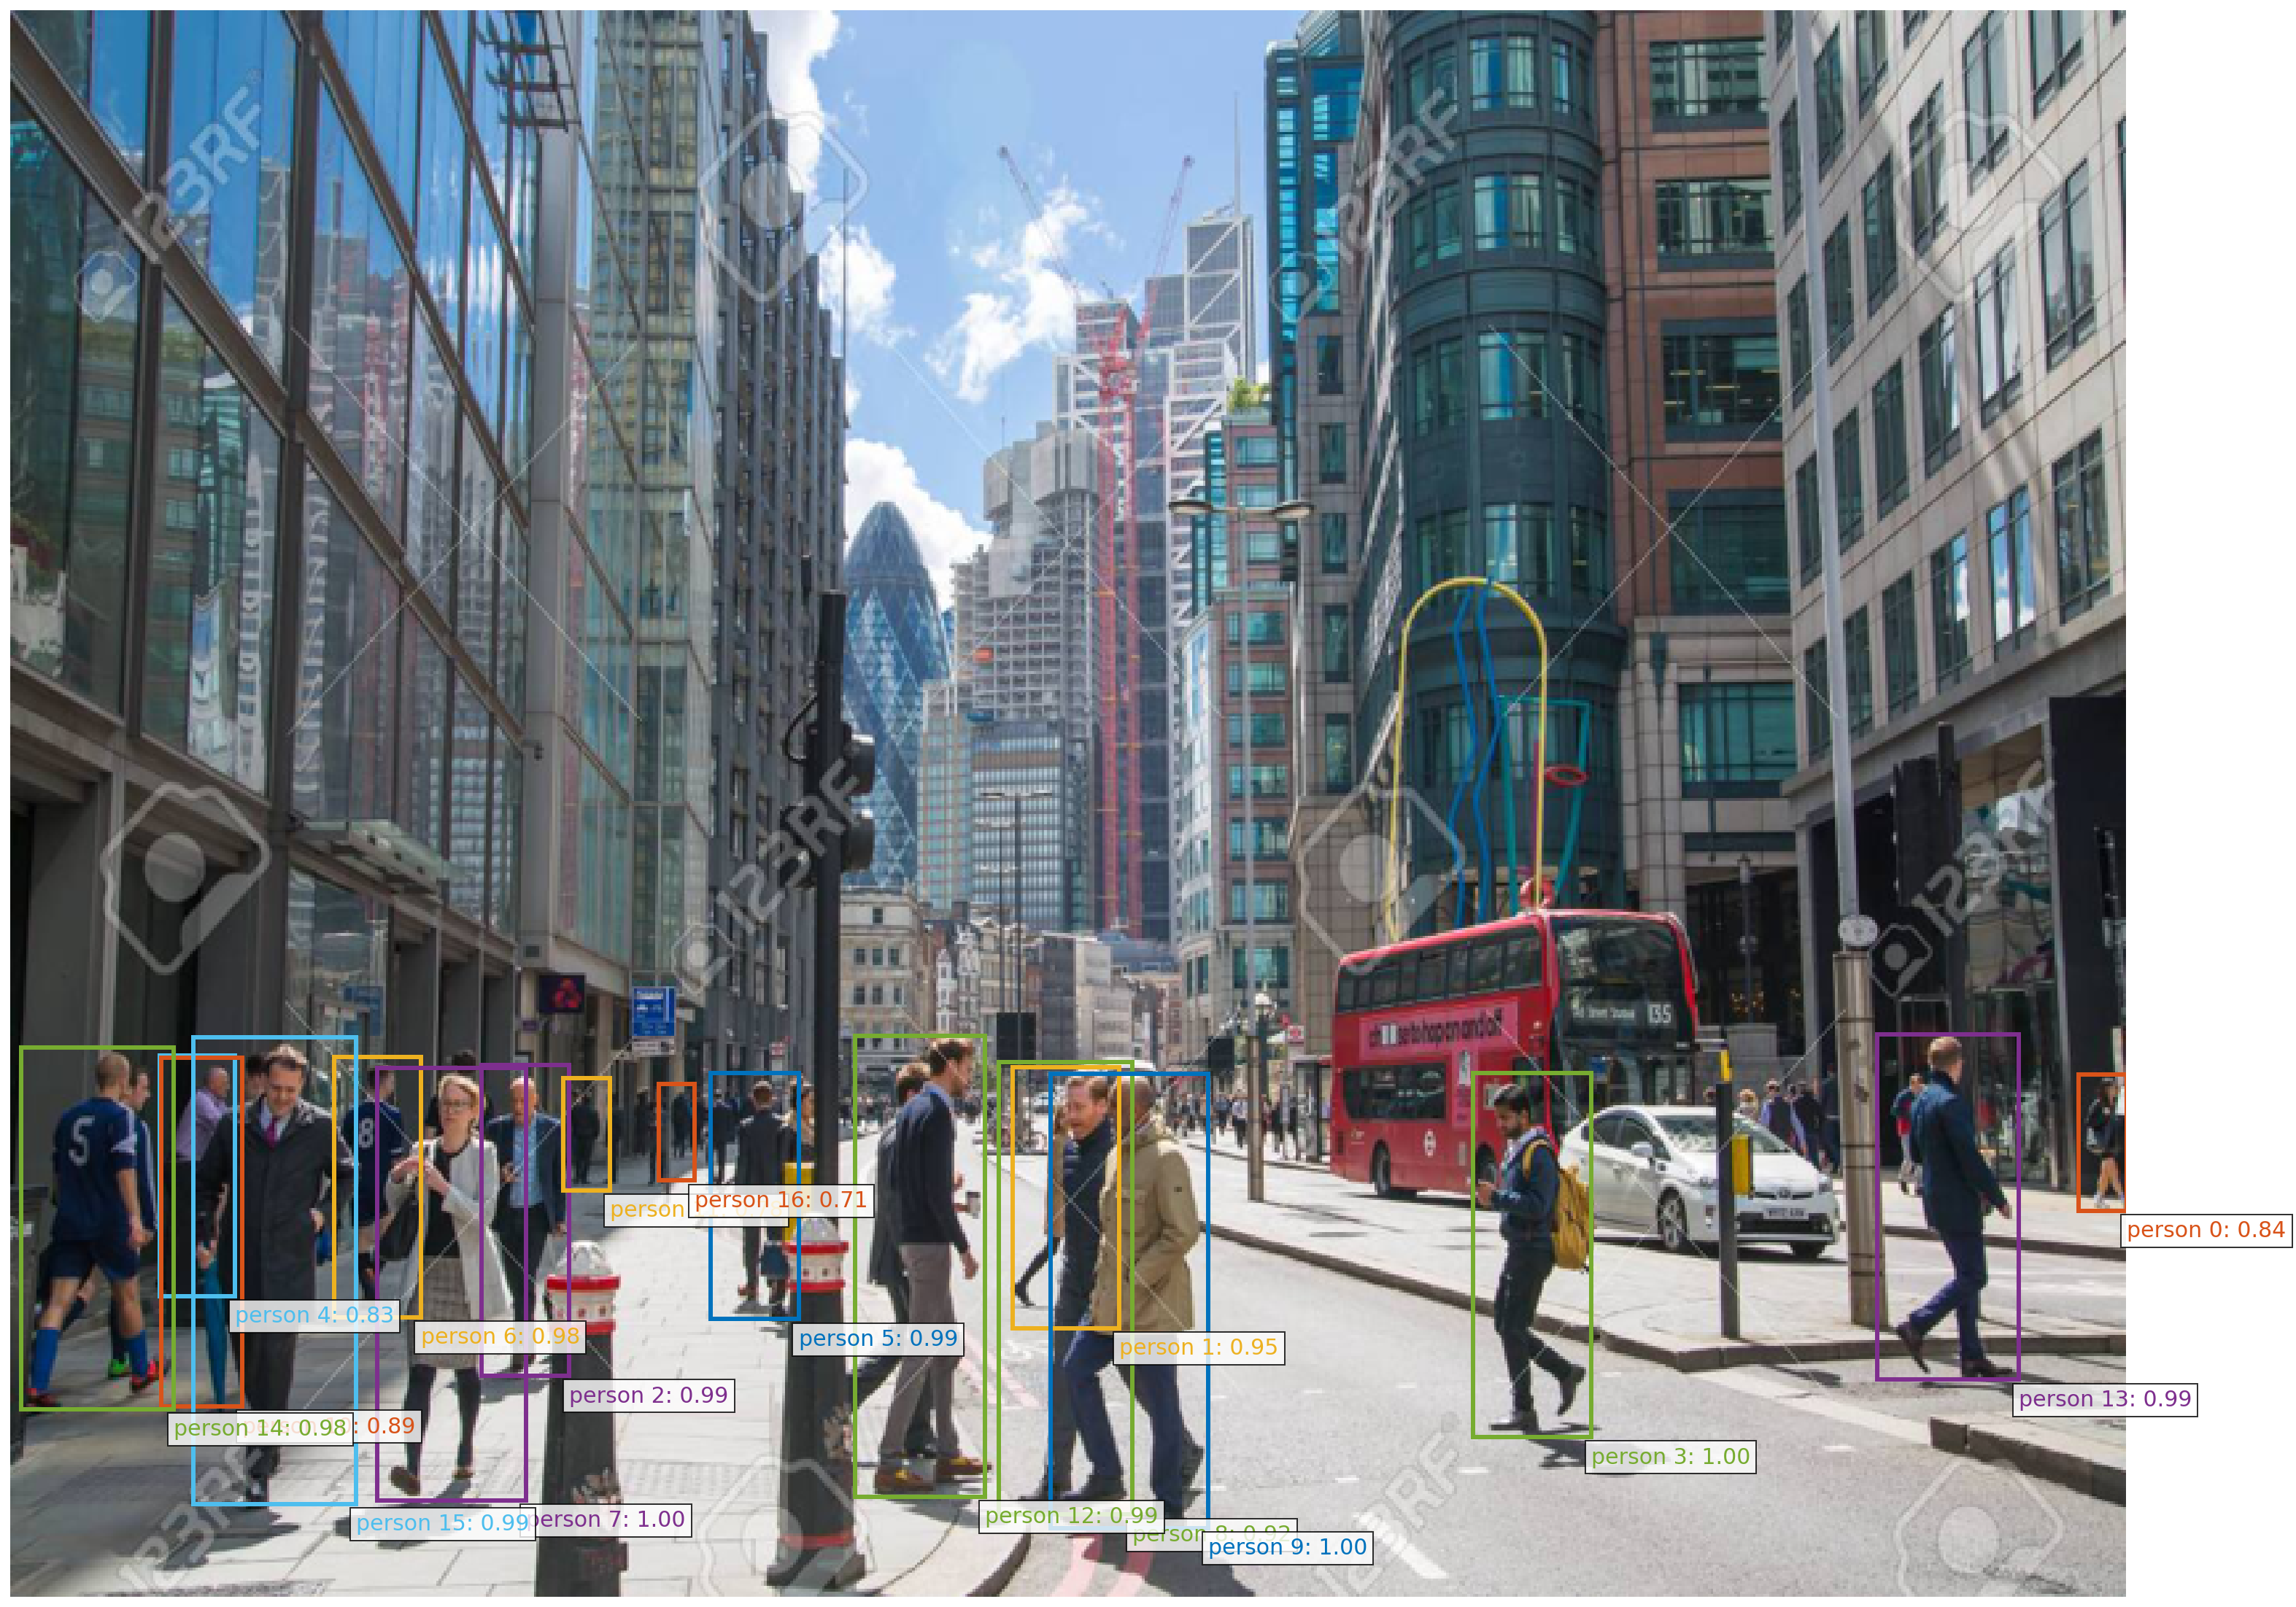

In [ ]:

url = input("Paste Image url: ")
im = Image.open(requests.get(url, stream=True).raw).resize((800,600))

scores, boxes = detect(im, model, transform)
plot_results(im, scores, boxes)

# ** Proximity Analysis *Incomplete***

In [ ]:
keyz = []
for key in peoplePos.keys():
  keyz.append(key)

In [ ]:
import numpy as np
diff = dict()
for j in range (0,len(keyz)):
  for i in range(0,len(keyz)):
    if j == i:
      diff[keyz[j]] = peoplePos[keyz[i]]
      continue
    diff[keyz[j]] = np.subtract(peoplePos[keyz[j]],peoplePos[keyz[i]])


In [ ]:
diff

{'person0': array([ 2.27352905,  7.4858551 , 14.97171021]),
 'person1': array([13.42642212, 31.10836792, 62.21673584]),
 'person10': array([ 8.48931122, 47.7064209 , 95.4128418 ]),
 'person11': array([1.9681015 , 2.94548035, 5.89096069]),
 'person12': array([ 17.76669312,  68.95135498, 137.90270996]),
 'person13': array([19.87637329, 47.01631165, 94.03262329]),
 'person14': array([ 21.97967887,  50.16223145, 100.32446289]),
 'person15': array([ 24.01570129,  69.91999817, 139.83999634]),
 'person16': [6.811309814453125, 18.3096923828125, 36.619384765625],
 'person2': array([ 9.73049164, 40.41760254, 80.83520508]),
 'person3': array([ 15.47238159,  50.55114746, 101.10229492]),
 'person4': array([ 7.36297607, 27.26483154, 54.52966309]),
 'person5': array([ 9.83302307, 28.25663757, 56.51327515]),
 'person6': array([ 9.50879669, 30.92497253, 61.84994507]),
 'person7': array([ 21.35210419,  63.49996948, 126.99993896]),
 'person8': array([ 18.46296692,  67.23077393, 134.46154785]),
 'person9'